## Adam vs. AMSGrad - Logistic Regression


### Logistic Regression with TF/Keras Library
In this section, we will implement logistic regression and apply on Fashion MNIST database. The database contains images of articles of clothing and the task is to classify these images as one of a select number of labels. Training set contains $60000$ images and Test set contains $10000$ images. There are a total of $10$ class labels. Each image is a $28 \times 28$ matrix of pixel values.

In [51]:
!pip install -q seaborn

In [59]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import math
import random

np.set_printoptions(precision=3, suppress=True)

#### Download the data

In [2]:
from tensorflow import keras
fashion_mnist = keras.datasets.fashion_mnist
(trImages, trLabels), (tImages, tLabels) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [3]:
print(np.shape(trImages))
print(np.shape(tImages))

(60000, 28, 28)
(10000, 28, 28)


In [30]:
print(np.shape(trLabels))
print(np.shape(tLabels))

(60000,)
(10000,)


#### Flatten the data

In [34]:
trImages = trImages.reshape(60000, 28*28)
tImages = tImages.reshape(10000, 28*28)

In [37]:
np.max(trImages[0])

1.0

#### Single Layer Implenmentation
There is an input layer where each image is flattened into a vector of $28 \times 28 = 784$ elements and fed into a **Softmax** layer. Output of softmax layer are probabilities of the image belonging to one of the possible $10$ class labels. 

In [4]:
# Training Parameters
batchSize = 128
nEpochs = 150

Building the network

In [36]:
# Define a sequential model
model = tf.keras.Sequential()

# Layer 0 falttens the image input
# layer0 = tf.keras.layers.Flatten(input_shape=np.shape(trImages[0]),name='Images')
# model.add(layer0)

# Layer1 is the output layer
numUnits_L1 = 10
layer1 = tf.keras.layers.Dense(units=numUnits_L1, activation=tf.nn.softmax, use_bias=True, name='Logistic')
model.add(layer1)

# Compile model with Adam optimizer
model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.005),
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
    )

Training the model

In [ ]:
trHistory = model.fit(
    x=trImages, 
    y=trLabels, 
    batch_size=batchSize, 
    epochs=nEpochs,
    shuffle=False, 
    validation_split=0.0)

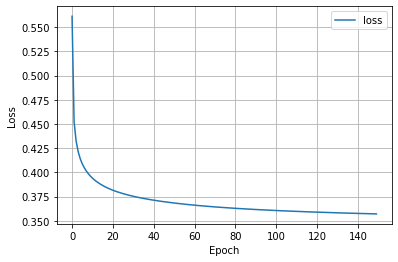

In [41]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.grid(True)

plot_loss(trHistory)

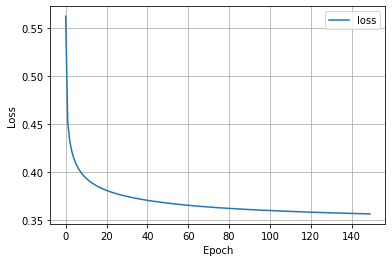

In [58]:
# Train another model with AMSGrad
model_amsgrad = tf.keras.Sequential()
layer1_amsgrad = tf.keras.layers.Dense(units=10, activation=tf.nn.softmax, use_bias=True, name='Logistic')
model_amsgrad.add(layer1_amsgrad)

# Compile model with AMSGrad
model_amsgrad.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.005, amsgrad=True),
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
    )

trHistory_amsgrad = model_amsgrad.fit(
    x=trImages, 
    y=trLabels, 
    batch_size=batchSize, 
    epochs=nEpochs,
    shuffle=False, 
    verbose=0,
    validation_split=0.0)

plot_loss(trHistory_amsgrad)

#### Find preconditioned data matrix

In [42]:
print("Condition Number A: ", np.linalg.cond(trImages.T @ trImages))

P = np.sqrt(np.linalg.inv(np.diag(np.diag(trImages.T @ trImages))))
conditioned_A = P@trImages.T@trImages@P

print("Condition Number Jacobi Preconditioner: ", np.linalg.cond(conditioned_A))

Condition Number A:  1096879839.537045
Condition Number Jacobi Preconditioner:  146238.75368581453


In [72]:
P_Jacobi = P

In [43]:
conditioned_A.shape

(784, 784)

### Adam vs. AMSGrad w/ Interative Function

In [44]:
def plot_loss_2(history_adam, history_amsgrad):
  try:
    plt.plot(history_adam.history['loss'], label='adam train loss')
    plt.plot(history_amsgrad.history['loss'], label='amsgrad train loss')
  except:
    print("Break")
    pass
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.grid(True)
  plt.show()

In [65]:
# function to generate a random diagonal matrix
def random_diag(dim):

  diagonal_entries = np.random.randint(low = 0, high = 255, size = dim)
  P = np.diag(diagonal_entries/255.0)

  return P

def random_gaussian_diag_func(dim):
  """
  Outputs diaginal matrix P with entries 
  Gaussian (mu=0, sigma=.1). If value is nagative, 
  replaced with zero. 
  """

  mu, sigma = 0, 0.1 # mean and standard deviation
  s = np.random.normal(mu, sigma, dim)

  vec = [0 if x < 0 else x for x in s]
  P = np.diag(vec)

  return P

In [76]:
def random_diag_mat(num_iter, lr, nEpochs, batchSize, patience, monitor, mat_type):
  
  # Number of epochs with no improvement after which training will be stopped
  callback = tf.keras.callbacks.EarlyStopping(monitor=monitor, patience=patience)

  # Instantiate running lists
  total_history_adam = []
  total_history_amsgrad = []
  total_epochs_for_convergence_adam = []
  total_epochs_for_convergence_amsgrad = []

  for i in range(num_iter):
    if mat_type == 'random':
      P = random_diag(dim=784)
      D = trImages @ P
    elif mat_type == 'jacobi':
      D = trImages @ P_Jacobi

    # Convert Data to Tensor
    data_input = tf.convert_to_tensor(D, dtype = tf.float32)

  
    print("------------ Iter: ", i+1, " ------------")
    print("\nCondition Number: ", round(np.linalg.cond(D),2))

    # Defining Models for Adama and AMSGrad and compiling
    logistic_model_adam = tf.keras.Sequential()
    layer_adam = tf.keras.layers.Dense(units=10, activation=tf.nn.softmax, use_bias=True, name='Logistic')
    logistic_model_adam.add(layer_adam)
    logistic_model_adam.compile(
        optimizer=tf.optimizers.Adam(learning_rate=lr), 
        loss='sparse_categorical_crossentropy', 
        metrics=['accuracy']
        )
    
    logistic_model_amsgrad = tf.keras.Sequential()
    layer_amsgrad = tf.keras.layers.Dense(units=10, activation=tf.nn.softmax, use_bias=True, name='Logistic')
    logistic_model_amsgrad.add(layer_amsgrad)
    logistic_model_amsgrad.compile(
        optimizer=tf.optimizers.Adam(learning_rate=lr, amsgrad=True), 
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
        )
    
    # Run Models
    history_adam = logistic_model_adam.fit(
      x=data_input, 
      y=trLabels, 
      batch_size=batchSize, 
      epochs=nEpochs,
      shuffle=False, 
      verbose=0,
      validation_split=0.0,
      callbacks=[callback])

    history_amsgrad = logistic_model_amsgrad.fit(
      x=data_input, 
      y=trLabels, 
      batch_size=batchSize, 
      epochs=nEpochs,
      shuffle=False, 
      verbose=0,
      validation_split=0.0,
      callbacks=[callback])

    epochs_adam = len(history_adam.history['loss'])
    epochs_amsgrad = len(history_amsgrad.history['loss'])

    # Printing number of epochs for convergence as defined by callback 
    print("Adam Epochs to Convergence: ",  epochs_adam)
    print("AMSGrad Epochs to Convergence", epochs_amsgrad)
    #c

    # Plot
    plot_loss_2(history_adam, history_amsgrad)

    total_epochs_for_convergence_adam.append(epochs_adam)
    total_epochs_for_convergence_amsgrad.append(epochs_amsgrad)

    total_history_adam.append(history_adam)
    total_history_amsgrad.append(history_amsgrad)

  return total_history_adam, total_history_amsgrad, total_epochs_for_convergence_adam, total_epochs_for_convergence_amsgrad

#### Run w/ Different Random Matrices

------------ Iter:  1  ------------

Condition Number:  7.905763036765777e+17
Adam Epochs to Convergence:  150
AMSGrad Epochs to Convergence 150


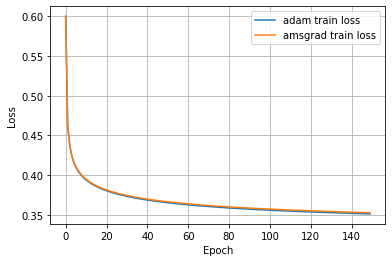

------------ Iter:  2  ------------

Condition Number:  8.639430596875428e+18
Adam Epochs to Convergence:  150
AMSGrad Epochs to Convergence 150


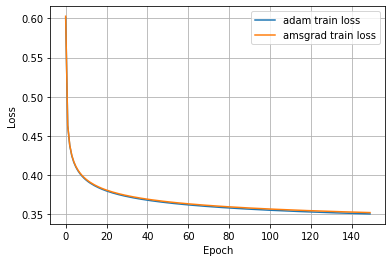

------------ Iter:  3  ------------

Condition Number:  7.896352267109096e+19
Adam Epochs to Convergence:  150
AMSGrad Epochs to Convergence 150


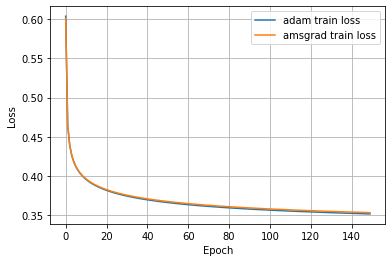

In [74]:
hist_adam, hist_amsgrad, epoch_adam, epoch_amsgrad = random_diag_mat(num_iter=3, lr=0.005, nEpochs=150, batchSize=128, patience=3, monitor='loss', mat_type='random')

### Run w/ Jacobi Preconditioned Matrix

------------ Iter:  1  ------------

Condition Number:  382.41
Adam Epochs to Convergence:  150
AMSGrad Epochs to Convergence 150


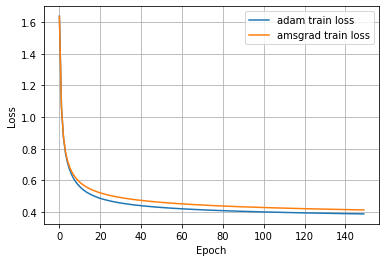

------------ Iter:  2  ------------

Condition Number:  382.41
Adam Epochs to Convergence:  150
AMSGrad Epochs to Convergence 150


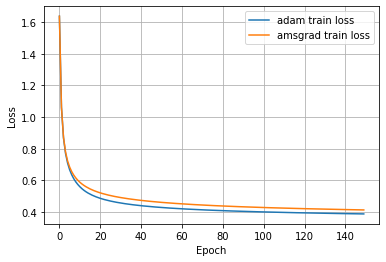

------------ Iter:  3  ------------

Condition Number:  382.41
Adam Epochs to Convergence:  150
AMSGrad Epochs to Convergence 150


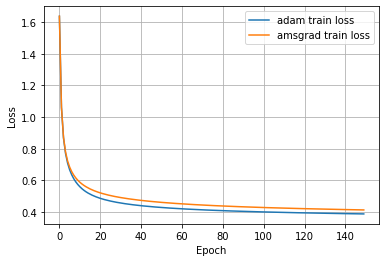

In [77]:
hist_adam, hist_amsgrad, epoch_adam, epoch_amsgrad = random_diag_mat(num_iter=3, lr=0.005, nEpochs=150, batchSize=128, patience=3, monitor='loss', mat_type='jacobi')

### Changing Hyperparameters $\beta_1, \beta_2$

In [78]:
def random_diag_mat_1(num_iter, lr, nEpochs, batchSize, patience, monitor, mat_type):
  
  # Number of epochs with no improvement after which training will be stopped
  callback = tf.keras.callbacks.EarlyStopping(monitor=monitor, patience=patience)

  # Instantiate running lists
  total_history_adam = []
  total_history_amsgrad = []
  total_epochs_for_convergence_adam = []
  total_epochs_for_convergence_amsgrad = []

  for i in range(num_iter):
    if mat_type == 'random':
      P = random_diag(dim=784)
      D = trImages @ P
    elif mat_type == 'jacobi':
      D = train_features @ P_Jacobi

    # Convert Data to Tensor
    data_input = tf.convert_to_tensor(D, dtype = tf.float32)

  
    print("------------ Iter: ", i+1, " ------------")
    print("\nCondition Number: ", round(np.linalg.cond(D),2))

    # Defining Models for Adama and AMSGrad and compiling
    logistic_model_adam = tf.keras.Sequential()
    layer_adam = tf.keras.layers.Dense(units=10, activation=tf.nn.softmax, use_bias=True, name='Logistic')
    logistic_model_adam.add(layer_adam)
    logistic_model_adam.compile(
        optimizer=tf.optimizers.Adam(learning_rate=lr, beta_1=0, beta_2=0.05), 
        loss='sparse_categorical_crossentropy', 
        metrics=['accuracy']
        )
    
    logistic_model_amsgrad = tf.keras.Sequential()
    layer_amsgrad = tf.keras.layers.Dense(units=10, activation=tf.nn.softmax, use_bias=True, name='Logistic')
    logistic_model_amsgrad.add(layer_amsgrad)
    logistic_model_amsgrad.compile(
        optimizer=tf.optimizers.Adam(learning_rate=lr, beta_1=0, beta_2=0.05, amsgrad=True), 
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
        )
    
    # Run Models
    history_adam = logistic_model_adam.fit(
      x=data_input, 
      y=trLabels, 
      batch_size=batchSize, 
      epochs=nEpochs,
      shuffle=False, 
      verbose=0,
      validation_split=0.0,
      callbacks=[callback])

    history_amsgrad = logistic_model_amsgrad.fit(
      x=data_input, 
      y=trLabels, 
      batch_size=batchSize, 
      epochs=nEpochs,
      shuffle=False, 
      verbose=0,
      validation_split=0.0,
      callbacks=[callback])

    epochs_adam = len(history_adam.history['loss'])
    epochs_amsgrad = len(history_amsgrad.history['loss'])

    # Printing number of epochs for convergence as defined by callback 
    print("Adam Epochs to Convergence: ",  epochs_adam)
    print("AMSGrad Epochs to Convergence", epochs_amsgrad)
    #c

    # Plot
    plot_loss_2(history_adam, history_amsgrad)

    total_epochs_for_convergence_adam.append(epochs_adam)
    total_epochs_for_convergence_amsgrad.append(epochs_amsgrad)

    total_history_adam.append(history_adam)
    total_history_amsgrad.append(history_amsgrad)

  return total_history_adam, total_history_amsgrad, total_epochs_for_convergence_adam, total_epochs_for_convergence_amsgrad

------------ Iter:  1  ------------

Condition Number:  1.155648378548491e+19
Adam Epochs to Convergence:  6
AMSGrad Epochs to Convergence 150


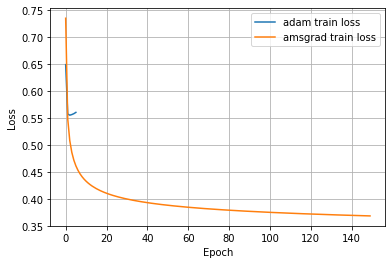

In [81]:
hist_adam, hist_amsgrad, epoch_adam, epoch_amsgrad = random_diag_mat_1(num_iter=1, lr=0.005, nEpochs=150, batchSize=128, patience=3, monitor='loss', mat_type='random')